## Playing around with flows

This notebook shows some first steps using flows.

In [393]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [394]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0
TF  Version 2.0.0


In [529]:
plt.figure(figsize=(6,6))
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen


<Figure size 600x600 with 0 Axes>

### Change of variables numerical [solution]

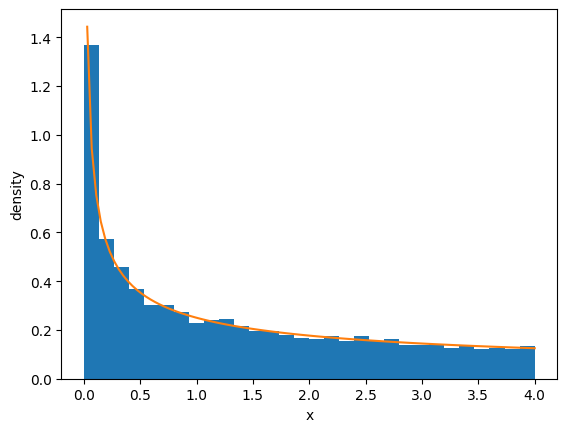

In [395]:
N = 10000
d = tfd.Uniform(low=0, high=2)
zs = d.sample(N)
x = zs**2

plt.hist(x, density=True, bins=30)
plt.ylabel('density')
plt.xlabel('x')

xs = np.linspace(0.03,4,100)
plt.plot(xs, 1./2 * 1./2 * 1/np.sqrt(xs))
plt.show()

### The Bijector package tfp.bijectors

Let's take the square as a bijector

z -- f(z)=z^2 --> x

In [396]:
f = tfb.Square() # This is a bijector
f.forward(2.0) #4
f.inverse(4.0) #2

<tf.Tensor: id=17791094, shape=(), dtype=float32, numpy=2.0>

Let's use the uniform distribution as a base transformation 

In [397]:
base_dist = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution(distribution=base_dist, bijector=f)

In [398]:
mydist.prob(3)

<tf.Tensor: id=17791141, shape=(), dtype=float32, numpy=0.14433756>

(0, 1)

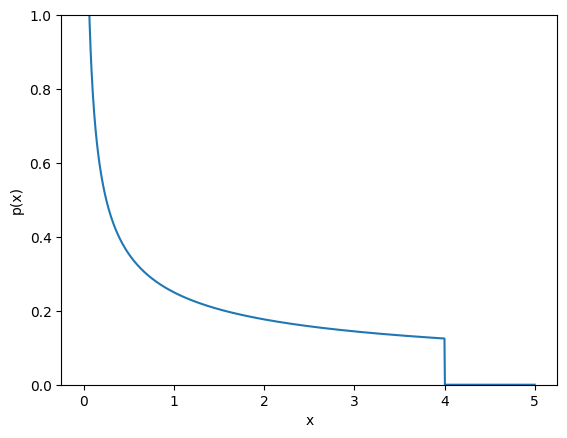

In [399]:
g = tfb.Square() #A 
db = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution( #B
    distribution=db, bijector=g)

xs = np.linspace(0.001, 5,1000)
px = mydist.prob(xs)

#A The bijector
#B Combining a base distribution and a bijector to a new distribution 

plt.plot(xs,px)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.ylim(0,1)

Text(0, 0.5, 'y')

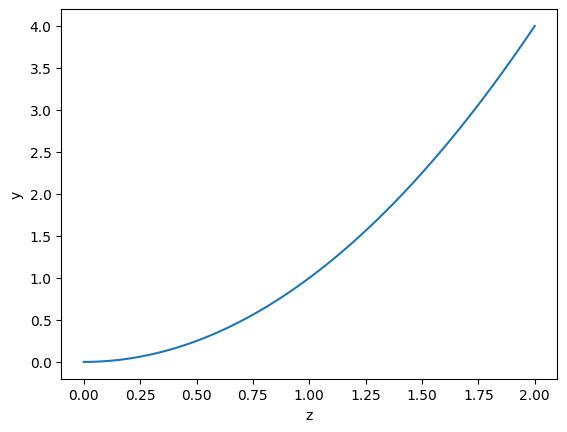

In [400]:
zz = np.linspace(0,2,100)
plt.plot(zz, g.forward(zz))
plt.xlabel('z')
plt.ylabel('y')

## Using several bijectors

In [401]:
chain = tfb.Chain([tfb.Square(), tfb.Square()], name="x4")
chain.forward(2.0)

<tf.Tensor: id=17791249, shape=(), dtype=float32, numpy=16.0>

# Training Bijectors

An extremly simple example, to go from a $N(0,1)$ Gaussian to a $N(5.0,0.2)$ Gaussian. 

#### Training Data
Let's sample some training data of our traget distribution:

(1000, 1)

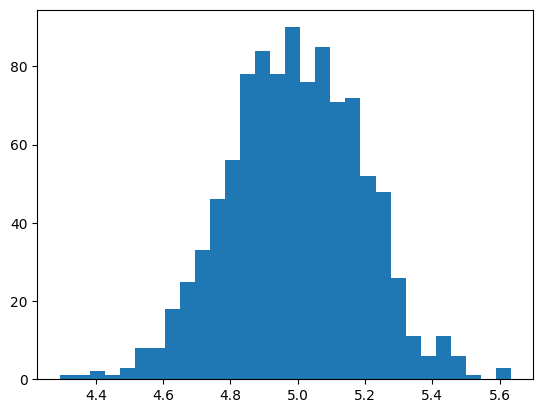

In [402]:
N = 1000
X = tfd.Normal(loc=5,scale=0.2).sample(1000)
X = X.numpy().reshape([N,1])
plt.hist(X,30)
X.shape

#### The simplest flow 


Building the flow using an Affine transformation in 1-D. Simply shift ($b$) and scale ($a$).

$$
    x = a \cdot z + b
$$


In [403]:
#Making a distribution using the flow and a N(0,1)
shift = tf.Variable(0.0)
scale=tf.Variable(1.0)
bijector = tfb.AffineScalar(shift=shift, scale=scale)
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1),bijector=bijector)
dist.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>)

In [404]:
-tf.reduce_mean(dist.log_prob(X)) #The NLL of the whole training set

<tf.Tensor: id=17791342, shape=(), dtype=float32, numpy=13.397392>

### Training in eager mode

What shall be the result? 

$z \sim N(0,1) \overbrace{\longrightarrow}^{f(z) = a\cdot z + b} x \sim N(5,0.2)$. 

Hence, $b = 5$ and $a = 0.2$

In [405]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1) #quite high lr for normalizing flows.

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) 
        gradients = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dist.trainable_variables))
    if (i % 100 == 0):
        print(i, "NLL ",loss.numpy(), " shift (a) ", shift.numpy(), " scale (b) ", scale.numpy())

0 NLL  13.397392  shift (a)  0.099999934  scale (b)  1.1
100 NLL  1.9093274  shift (a)  3.9791694  scale (b)  2.4480221
200 NLL  0.20094235  shift (a)  4.991875  scale (b)  0.38849914
300 NLL  -0.20008655  shift (a)  4.9917817  scale (b)  0.19733803
400 NLL  -0.20009406  shift (a)  4.99176  scale (b)  0.19808854
500 NLL  -0.20009404  shift (a)  4.9917603  scale (b)  0.19809017
600 NLL  -0.20009401  shift (a)  4.99176  scale (b)  0.19809018
700 NLL  -0.20009407  shift (a)  4.99176  scale (b)  0.1980902
800 NLL  -0.20009401  shift (a)  4.9917603  scale (b)  0.1980902
900 NLL  -0.20009401  shift (a)  4.99176  scale (b)  0.19809018


In [406]:
# In one line as in the book
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234

a = tf.Variable(1.0) #A 
b = tf.Variable(0.0) #A 
bijector = tfb.AffineScalar(shift=b, scale=a) #B
dist = tfd.TransformedDistribution(distribution=
        tfd.Normal(loc=0,scale=1),bijector=bijector)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) #C 
        gradients = tape.gradient(loss,          #D 
                    dist.trainable_variables)     
    optimizer.apply_gradients(
        zip(gradients, dist.trainable_variables)) #E     
    
    if (i % 100 == 0):
        print(i, "NLL ",loss.numpy(), " shift (a) ", a.numpy(), " scale (b) ", b.numpy())

        
#A Defining the variables 
#B We use Variables in definition of the flow
#C The NLL of the Data
#D Calcuation of the gradients for the variables
#E Applying the gradients

0 NLL  13.397392  shift (a)  1.1  scale (b)  0.099999934
100 NLL  1.9093274  shift (a)  2.4480221  scale (b)  3.9791694
200 NLL  0.20094235  shift (a)  0.38849914  scale (b)  4.991875
300 NLL  -0.20008655  shift (a)  0.19733803  scale (b)  4.9917817
400 NLL  -0.20009406  shift (a)  0.19808854  scale (b)  4.99176
500 NLL  -0.20009404  shift (a)  0.19809017  scale (b)  4.9917603
600 NLL  -0.20009401  shift (a)  0.19809018  scale (b)  4.99176
700 NLL  -0.20009407  shift (a)  0.1980902  scale (b)  4.99176
800 NLL  -0.20009401  shift (a)  0.1980902  scale (b)  4.9917603
900 NLL  -0.20009401  shift (a)  0.19809018  scale (b)  4.99176


Text(0.5, 0, 'x')

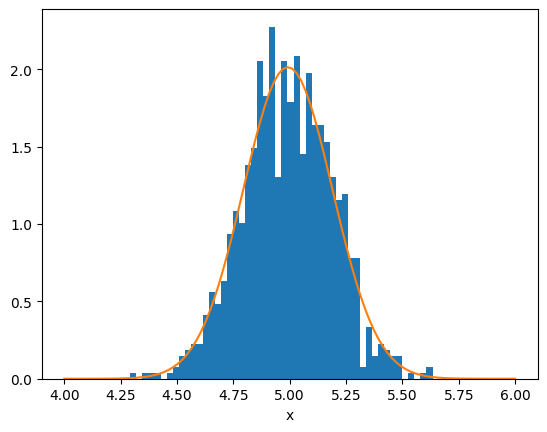

In [411]:
xx = np.linspace(4,6,100)
plt.hist(X, bins=50,density=True)
plt.plot(xx, dist.prob(xx) )
dist.trainable_variables
plt.xlabel('x')

In [412]:
dist.mean()
#dist.stddev() #not implemented for transformed model
dist.prob(4.6)
dist.quantile(0.2)

<tf.Tensor: id=18072080, shape=(), dtype=float32, numpy=4.8250427>

## Fitting the old faithful

(272, 1)

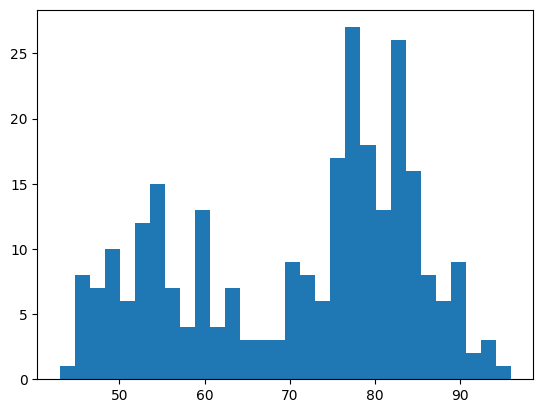

In [413]:
df1 = pd.read_csv('../data/faithful.csv', delimiter=',')
X = np.asarray(df1.iloc[:,2],dtype='float32').reshape((-1,1))
plt.hist(X,30)
X.shape

## Non-Linearity

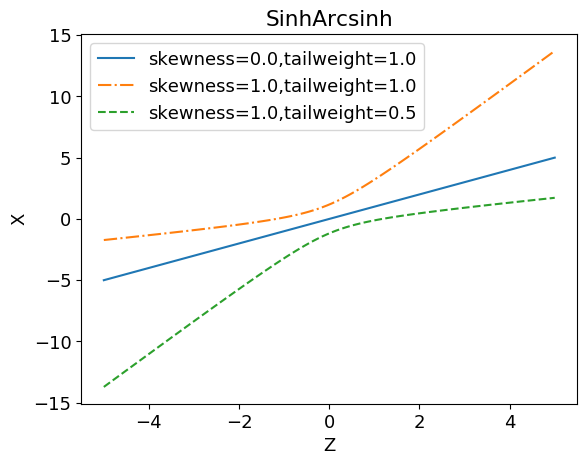

In [534]:
plt.rcParams.update({'font.size': 13}) #Macht grosse axen
zs = np.linspace(-5,5,100, dtype=np.float32)
plt.plot(zs, tfb.SinhArcsinh(skewness=0.0,tailweight=1.0).forward(zs))
plt.plot(zs, tfb.SinhArcsinh(skewness=1.0,tailweight=1.0).forward(zs),linestyle='-.')
plt.plot(zs, tfb.SinhArcsinh(skewness=-1.0,tailweight=1.0).forward(zs),linestyle='--')
plt.xlabel('Z')
plt.ylabel('X')
plt.title('SinhArcsinh')
plt.legend(['skewness=0.0,tailweight=1.0','skewness=1.0,tailweight=1.0','skewness=1.0,tailweight=0.5'])
plt.savefig('ch06_sin.pdf')

In [513]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234

num_bijectors = 5 #A 
bs=[]
for i in range(num_bijectors):
    
    shft = tf.Variable(0.0)
    sca=tf.Variable(1.0)
    bs.append(tfb.AffineScalar(shift=shft, scale=sca))#B
    
    skewness=tf.Variable(0.0)
    tailweight=tf.Variable(1.0) 
    bs.append(tfb.SinhArcsinh(skewness,tailweight))#C
    

bijector = tfb.Chain(bs) #D
dist = tfd.TransformedDistribution(distribution=
        tfd.Normal(loc=0,scale=1),bijector=bijector)

#A Number of layers
#B The AffineScalar transformation
#C The SinhArcsinh acting as non-linearity
#D Creating the chain of bijectors from the list bijectors

In [514]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(X):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) #C 
        gradients = tape.gradient(loss,dist.trainable_variables)     
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables)) #E 
        return loss

for i in range(20000):
    loss = train_step(X)
    if (i % 500 == 0 or i < 5):
        print(i, "NLL ",loss.numpy())

0 NLL  2606.1877
1 NLL  1541.5117
2 NLL  962.5718
3 NLL  635.1125
4 NLL  440.9034
500 NLL  5.8686886
1000 NLL  4.679427
1500 NLL  4.5295877
2000 NLL  4.386953
2500 NLL  4.2590623
3000 NLL  4.1719074
3500 NLL  4.1287775
4000 NLL  4.1083465
4500 NLL  4.09114
5000 NLL  4.0709167
5500 NLL  4.047118
6000 NLL  4.0207634
6500 NLL  3.9941614
7000 NLL  3.9706008
7500 NLL  3.9529958
8000 NLL  3.9419434
8500 NLL  3.9352283
9000 NLL  3.9291508
9500 NLL  3.9126632
10000 NLL  3.8819408
10500 NLL  3.8593805
11000 NLL  3.8502147
11500 NLL  3.8456025
12000 NLL  3.8407445
12500 NLL  3.835162
13000 NLL  3.829282
13500 NLL  3.8238122
14000 NLL  3.8189259
14500 NLL  3.815092
15000 NLL  3.8117115
15500 NLL  3.8090973
16000 NLL  3.8069062
16500 NLL  3.8069692
17000 NLL  3.8037918
17500 NLL  3.8019543
18000 NLL  3.800556
18500 NLL  3.7993872
19000 NLL  3.7983184
19500 NLL  3.7973938


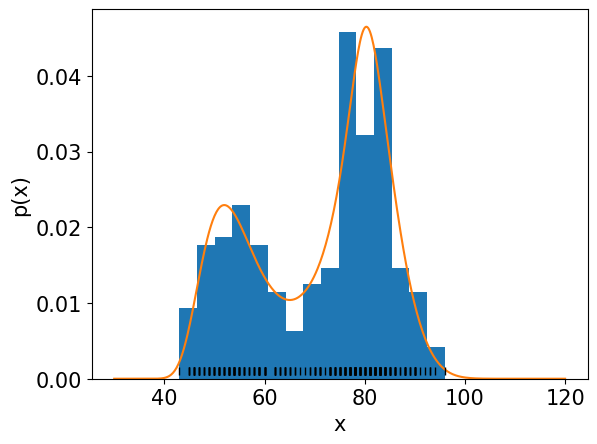

In [530]:
plt.rcParams.update({'font.size': 15}) #Macht grosse axen
plt.hist(X, 15,density=True)
xs = np.linspace(30,120,500)
plt.plot(xs, dist.prob(xs))
plt.plot(X, [0.001]*len(X), '|', color='k')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.savefig('ch06_gey.pdf')

Text(0, 0.5, 'x')

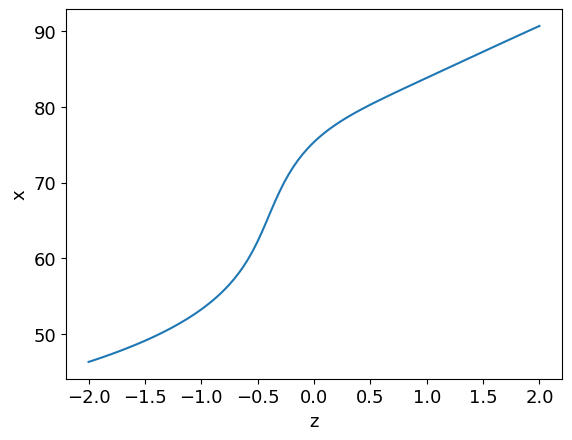

In [535]:
zz = np.linspace(-2,2,100)
plt.plot(zz, bijector.forward(zz))
plt.xlabel('z')
plt.ylabel('x')

Text(0, 0.5, 'x')

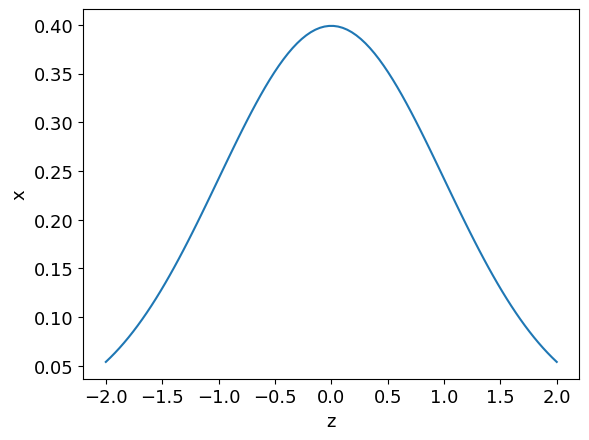

In [537]:
zz = np.linspace(-2,2,100)

plt.plot(zz, tfd.Normal(loc=0,scale=1).prob(zz))
plt.xlabel('z')
plt.ylabel('x')